## Grouping unlabeled items using k-means clustering

- Pros: Easy to implement
- Cons: Can converge at local minima; slow on very large datasets
- Works with: Numeric values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

### Implement KMeans

In [2]:
# k-means support functions
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))


def randCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros((k, n)))
    # Create cluster centroids
    for j in range(n):
        minJ = min(dataSet[:, j])
        rangeJ = float(max(dataSet[:, j]) - minJ)
        centroids[:, j] = np.mat(minJ + rangeJ * np.random.rand(k, 1))
    return centroids

In [3]:
# The k-means clustering algorithm
# Create k points for starting centroids (often randomly)
# While any point has changed cluster assignment
#     for every point in our dataset:
#         for every centroid
#             calculate the distance between the centroid and point
#         assign the point to the cluster with the lowest distance
#     for every cluster calculate the mean of the points in that cluster
#         assign the centroid to the mean
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m, 2)))
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            # Find the closest centroid
            for j in range(k):
                distJI = distMeas(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist ** 2
        # print(centroids)
        # Update centroid location
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]]
            centroids[cent, :] = np.mean(ptsInClust, axis=0)
    return centroids, clusterAssment

In [4]:
# The bisecting k-means clustering algorithm
# Start with all the points in one cluster
# While the number of clusters is less than k
#     for every cluster
#         measure total error
#         perform k-means clustering with k=2 on the given cluster
#         measure total error after k-means has split the cluster in two
#     choose the cluster split that gives the lowest error
#     and commit this split
def biKmeans(dataSet, k, distMeas=distEclud):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m, 2)))
    # Initially create one cluster
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    centList = [centroid0]
    for j in range(m):
        clusterAssment[j, 1] = distMeas(np.mat(centroid0), dataSet[j, :]) ** 2
    while len(centList) < k:
        lowestSSE = np.inf
        for i in range(len(centList)):
            # Try splitting every cluster
            ptsInCurrCluster = dataSet[
                np.nonzero(clusterAssment[:, 0].A == i)[0], :]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:, 1])
            sseNotSplit = sum(
                clusterAssment[np.nonzero(clusterAssment[:, 0].A != i)[0], 1])
            # print("sseSplit, and notSplit: ", sseSplit, sseNotSplit)
            if sseSplit + sseNotSplit < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        # Update the cluster assignments
        bestClustAss[
            np.nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)
        bestClustAss[
            np.nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit
        # print('the bestCentToSplit is: ',bestCentToSplit)
        # print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0, :].tolist()[0]
        centList.append(bestNewCents[1, :].tolist()[0])
        clusterAssment[np.nonzero(
            clusterAssment[:, 0].A == bestCentToSplit)[0], :] = bestClustAss
    return np.mat(centList), clusterAssment

### Experiment 1: Toy dataset

In [5]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

In [6]:
datMat = np.mat(loadDataSet('testSet.txt'))

In [7]:
myCentroids, clustAssing = kMeans(datMat, 4)

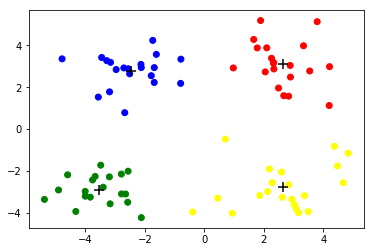

In [8]:
plt.figure()
plt.scatter(datMat.A[:, 0], datMat.A[:, 1], c=clustAssing.A[:, 0],
            cmap=ListedColormap(["red", "yellow", "blue", "green"]))
plt.scatter(myCentroids.A[:, 0], myCentroids.A[:, 1], s=100, color="black",
            marker="+")
plt.show()

In [9]:
datMat3 = np.mat(loadDataSet('testSet2.txt'))

In [10]:
centList, myNewAssments = biKmeans(datMat3, 3)

In [11]:
centList

matrix([[-0.45965615, -2.7782156 ],
        [ 2.93386365,  3.12782785],
        [-2.94737575,  3.3263781 ]])

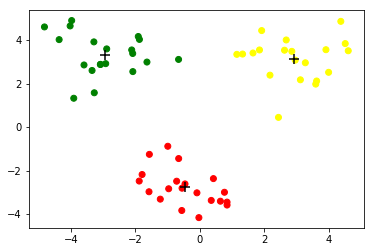

In [12]:
plt.figure()
plt.scatter(datMat3.A[:, 0], datMat3.A[:, 1], c=myNewAssments.A[:, 0],
            cmap=ListedColormap(["red", "yellow", "green"]))
plt.scatter(centList.A[:, 0], centList.A[:, 1], s=100, color="black",
            marker="+")
plt.show()

## Experiment 2: Map point dataset

In [13]:
# Spherical distance measure and cluster-plotting functions
def distSLC(vecA, vecB):
    a = np.sin(vecA[0, 1] * np.pi / 180) * np.sin(vecB[0, 1] * np.pi / 180)
    b = (np.cos(vecA[0, 1] * np.pi / 180) * np.cos(vecB[0, 1] * np.pi / 180) *
         np.cos(np.pi * (vecB[0, 0] - vecA[0, 0]) / 180))
    return np.arccos(a + b) * 6371.0


def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = np.mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    # Create matrix from image
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:, 0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0],
                    ptsInCurrCluster[:, 1].flatten().A[0],
                    marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:, 0].flatten().A[0],
                myCentroids[:, 1].flatten().A[0],
                marker='+', s=300)
    plt.show()

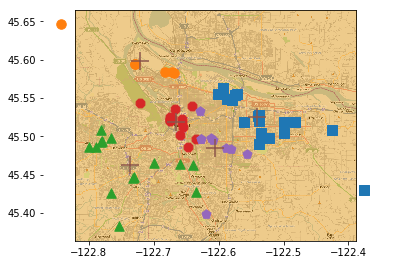

In [14]:
clusterClubs()